In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.covariance
import sklearn.cluster
import datetime

## Parameters

Set up input filenames. **met** file is for the weather dataset. **obs** file is for the phenology observation dataset (i.e. cherry blossom).

In [2]:
MET_FILENAME = '../../input/df/met/usa_ds3505.h5'
MET_LOCATION = 724050

In [3]:
OBS_FILENAME = '../../input/df/obs/cherry_dc.h5'
OBS_LOCATION = 'DC'

$L$ is a threshold determining how many samples we'd like to extract from top and bottom of the distribution. It is a proportion ranging from 0 to 1. Simply put, we're going to take 'Top $100L$%' and 'Bottom $100L$%' of the distribution.

In [4]:
L = 0.5

Specify months for chilling and heating (anti-chilling).

Note that the current year ends at September. For example, the year of 2017 starts from 2016-10 to 2017-09.

In [5]:
CHILL_MONTHS = [11, 12, 1]
HEAT_MONTHS = [2, 3, 4]

## Dataset

In [6]:
met = pd.read_hdf(MET_FILENAME).loc[MET_LOCATION]

In [7]:
obs = pd.read_hdf(OBS_FILENAME).loc[OBS_LOCATION]

There are years where some weather data are missing (i.e. '1969-09-01':'1972-12-31').

In [8]:
years = set(met.index.year) - set([1946, 1970, 1971, 1972, 1973])

In [9]:
years = years & set(obs.index.get_level_values('year'))

In [10]:
met = pd.concat([met.loc[f'{y-1}-10-01':f'{y}-09-30'] for y in years])

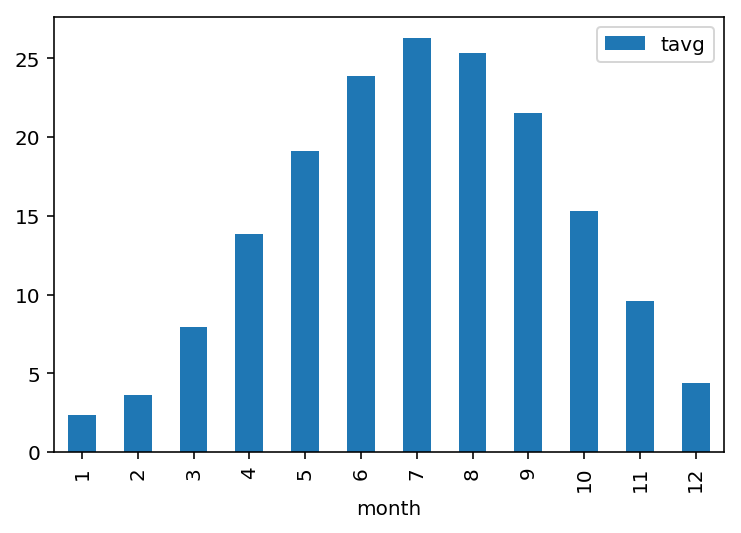

In [11]:
met.groupby(met.index.month).mean().rename_axis('month').plot.bar()

In [12]:
def extract_months(met, months):
    df = met.loc[met.index.month.isin(months)].resample('A-SEP').mean().dropna()
    return df.sort_values('tavg', ascending=False)

## Chill

In [13]:
chill = extract_months(met, CHILL_MONTHS)

In [14]:
chill.count()

tavg    77
dtype: int64

In [15]:
def count(df, threshold=L):
    assert 0 <= threshold <= 1
    return int(df.count() * threshold)

In [16]:
count(chill, L)

38

In [17]:
def top(df, threshold=L):
    t = count(df, threshold)
    return df[:t]

def bottom(df, threshold=L):
    t = count(df, threshold)
    return df[-t:]

In [18]:
chill.tavg.mean()

5.3925024379506

In [19]:
top(chill).tavg.mean()

6.670933870749759

In [20]:
bottom(chill).tavg.mean()

4.117718571214977

In [21]:
def plot(df, threshold=L):
    ax = df.plot(style='.', color='grey')
    top(df, threshold).plot(style='.', color='r', ax=ax)
    bottom(df, threshold).plot(style='.', color='b', ax=ax)
    ax.legend(['Others', f'Top {threshold*100:.0f}%', f'Bottom {threshold*100:.0f}%'])
    plt.axhline(y=df.tavg.mean(), color='k', ls=':')

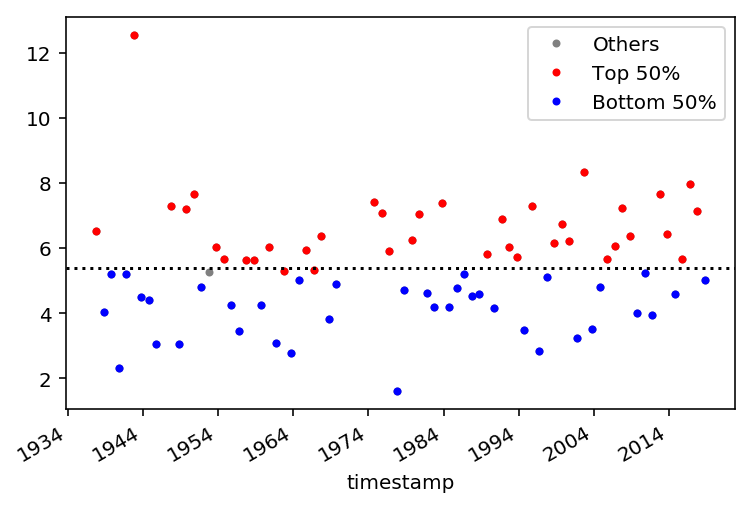

In [22]:
plot(chill)

In [23]:
def top_years(df, threshold=L):
    return set(top(df, threshold).index.year.sort_values())

def bottom_years(df, threshold=L):
    return set(bottom(df, threshold).index.year.sort_values())

In [24]:
chill_top_years = top_years(chill)

In [25]:
chill_bottom_years = bottom_years(chill)

In [26]:
chill_years = chill_top_years | chill_bottom_years

## Heat

In [27]:
heat = extract_months(met, HEAT_MONTHS)

In [28]:
heat.tavg.mean()

8.548622744274551

In [29]:
top(heat).tavg.mean()

9.536575648837655

In [30]:
bottom(heat).tavg.mean()

7.567419618572859

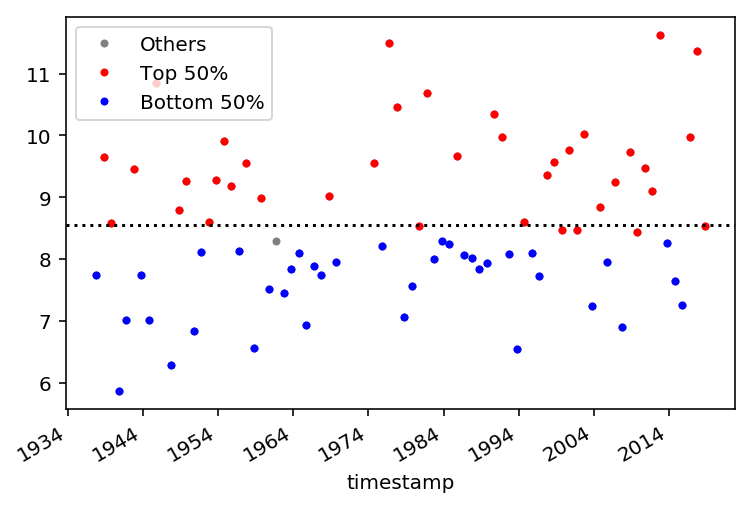

In [31]:
plot(heat)

In [32]:
heat_top_years = top_years(heat)

In [33]:
heat_bottom_years = bottom_years(heat)

In [34]:
heat_years = heat_top_years | heat_bottom_years

## Result

In [35]:
len(chill_years & heat_years)

75

Here are four possible combinations of chill and heat extremes. If we want more samples, increase threshold variable $L$ above and rerun the notebook.

In [36]:
chill_top_years & heat_top_years

{1942,
 1949,
 1953,
 1954,
 1957,
 1974,
 1976,
 1980,
 1991,
 1998,
 1999,
 2000,
 2002,
 2006,
 2008,
 2012,
 2016,
 2017}

In [37]:
chill_top_years & heat_bottom_years

{1937,
 1947,
 1950,
 1958,
 1960,
 1962,
 1965,
 1966,
 1967,
 1975,
 1979,
 1983,
 1989,
 1992,
 1993,
 1995,
 2005,
 2007,
 2013,
 2015}

In [38]:
chill_bottom_years & heat_top_years

{1938,
 1939,
 1945,
 1948,
 1955,
 1959,
 1968,
 1977,
 1981,
 1985,
 1990,
 1994,
 1997,
 2001,
 2004,
 2009,
 2010,
 2011,
 2018}

In [39]:
chill_bottom_years & heat_bottom_years

{1940,
 1941,
 1943,
 1944,
 1951,
 1956,
 1963,
 1964,
 1969,
 1978,
 1982,
 1984,
 1986,
 1987,
 1988,
 1996,
 2003,
 2014}